## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
plt.style.use("seaborn")
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)
records.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [12]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

# top 10 features iflg Correlation Heatmap
list_of_correlations.iloc[:,-1].sort_values(ascending=False).head(11)


## Normalize data

In [13]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [14]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [15]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
X = normalized_records[top10].to_numpy()
y = targets.to_numpy()

In [16]:
# Split into train/validation data
oversample = imblearn.over_sampling.SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

lrg3 = LogisticRegression()

X_train3, X_validation3, y_train3, y_validation3 = train_test_split(X_smote, y_smote, test_size=0.60, random_state=42)
lrg3.fit(X_train3, y_train3)

LogisticRegression()

In [17]:
# Create torch train/validation data sets

X_train_t = torch.from_numpy(X_train3).float()
y_train_t = torch.squeeze(torch.from_numpy(y_train3).float())
X_validation_t = torch.from_numpy(X_validation3).float()
y_validation_t = torch.squeeze(torch.from_numpy(y_validation3).float())

print(X_train_t.shape, y_train_t.shape)
print(X_validation_t.shape, y_validation_t.shape)

torch.Size([227452, 10]) torch.Size([227452])
torch.Size([341178, 10]) torch.Size([341178])


In [18]:
# Definition of NN structure

class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
net = Net(X_train_t.shape[1])

In [19]:
# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Accuracy function, as percentage of true predictions
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [20]:
# Training

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train_t)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train_t)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train_t, y_pred)

      y_test_pred = net(X_validation_t)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_validation_t)

      test_acc = calculate_accuracy(y_validation_t, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 0.719, accuracy: 0.5
Test  set - loss: 0.719, accuracy: 0.5

epoch 100
Train set - loss: 0.589, accuracy: 0.5
Test  set - loss: 0.589, accuracy: 0.5

epoch 200
Train set - loss: 0.453, accuracy: 0.5
Test  set - loss: 0.452, accuracy: 0.5

epoch 300
Train set - loss: 0.404, accuracy: 0.925
Test  set - loss: 0.403, accuracy: 0.925

epoch 400
Train set - loss: 0.372, accuracy: 0.938
Test  set - loss: 0.372, accuracy: 0.938

epoch 500
Train set - loss: 0.347, accuracy: 0.941
Test  set - loss: 0.346, accuracy: 0.941

epoch 600
Train set - loss: 0.327, accuracy: 0.943
Test  set - loss: 0.327, accuracy: 0.943

epoch 700
Train set - loss: 0.311, accuracy: 0.943
Test  set - loss: 0.311, accuracy: 0.942

epoch 800
Train set - loss: 0.295, accuracy: 0.943
Test  set - loss: 0.295, accuracy: 0.943

epoch 900
Train set - loss: 0.282, accuracy: 0.945
Test  set - loss: 0.282, accuracy: 0.944



In [21]:

classes = ['Normal', 'Fraudulent']

# Predict
y_pred = net(X_validation_t)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_validation_t.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.92      0.98      0.95    170561
  Fraudulent       0.98      0.91      0.94    170617

    accuracy                           0.95    341178
   macro avg       0.95      0.95      0.95    341178
weighted avg       0.95      0.95      0.95    341178



In [22]:
mlpclassifier = MLPClassifier(hidden_layer_sizes=(100,100), verbose=True)
mlpclassifier.fit(X_train3, y_train3)


Iteration 1, loss = 0.09034937
Iteration 2, loss = 0.03424041
Iteration 3, loss = 0.02103897
Iteration 4, loss = 0.01594476
Iteration 5, loss = 0.01300326
Iteration 6, loss = 0.01095365
Iteration 7, loss = 0.00950838
Iteration 8, loss = 0.00919845
Iteration 9, loss = 0.00819788
Iteration 10, loss = 0.00752855
Iteration 11, loss = 0.00730779
Iteration 12, loss = 0.00687838
Iteration 13, loss = 0.00631876
Iteration 14, loss = 0.00595401
Iteration 15, loss = 0.00524454
Iteration 16, loss = 0.00553686
Iteration 17, loss = 0.00498992
Iteration 18, loss = 0.00499638
Iteration 19, loss = 0.00474223
Iteration 20, loss = 0.00480911
Iteration 21, loss = 0.00430672
Iteration 22, loss = 0.00394749
Iteration 23, loss = 0.00403533
Iteration 24, loss = 0.00387693
Iteration 25, loss = 0.00358841
Iteration 26, loss = 0.00367391
Iteration 27, loss = 0.00328305
Iteration 28, loss = 0.00372609
Iteration 29, loss = 0.00348225
Iteration 30, loss = 0.00307118
Iteration 31, loss = 0.00355194
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(100, 100), verbose=True)

skf = StratifiedKFold(n_splits=10)
lrg = LogisticRegression()
accuracies = []
for train_index, test_index in tqdm(skf.split(X,y)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lrg.fit(X_train, y_train)
    accuracies.append(lrg.score(X_test, y_test))

print("Mean Logistic Regression Accuracy:", np.mean(accuracies))


In [23]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

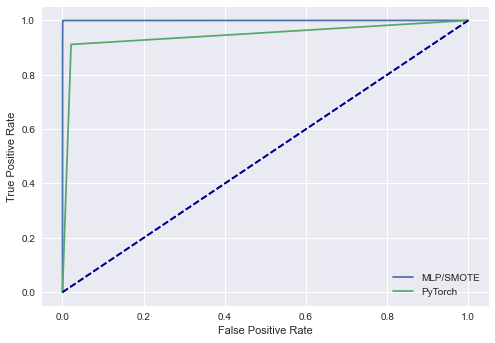

In [24]:

create_roc_curve(mlpclassifier.predict_proba(X_validation3)[:,1], y_validation3, label="MLP/SMOTE")
create_roc_curve(y_pred, y_test, label="PyTorch")

[0.9993345489297084, 0.9452686906244561]


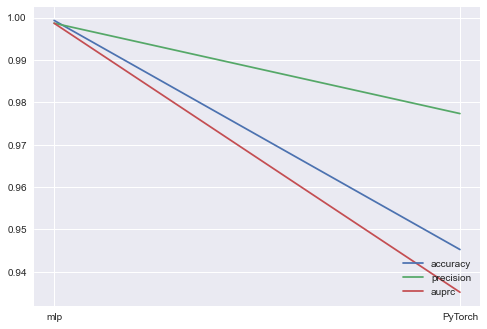

In [25]:

mlp = mlpclassifier.predict(X_validation3)

accur = [ roc_auc_score(y_validation3, mlp),  roc_auc_score(y_test, y_pred)]
precision = [ precision_score(y_validation3, mlp), precision_score(y_test, y_pred)]
auprc = [average_precision_score(y_validation3, mlp), average_precision_score(y_test, y_pred)]

print (accur)

labels = ['mlp','PyTorch']
plt.plot(labels, accur, label="accuracy")
plt.plot(labels, precision, label="precision")
plt.plot(labels, auprc, label="auprc")
plt.legend(loc='lower right')

# print(strat.shape, tts.shape, smot.shape, mlp.shape)


confusion = confusion_matrix(y_validation3, mlp)
print(confusion)

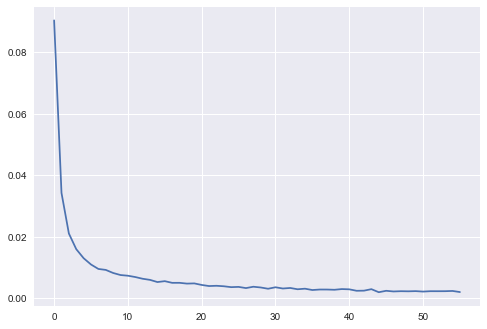

In [26]:
plt.plot(mlpclassifier.loss_curve_)
plt.show()